# OUTLIERS DETECTION

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import lightgbm as lgb

In [3]:
data = pd.read_parquet('./data/train.parquet')
data

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585
...,...,...,...,...,...,...,...,...,...,...,...
928450,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,51.0,2021-08-08 18:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.951244
928453,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,1.0,2021-08-09 02:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,0.693147
928456,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,61.0,2021-08-09 08:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,4.127134
928459,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,44.0,2021-08-09 10:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.806662


In [4]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, 'year'] = X['date'].dt.year
    X.loc[:, 'month'] = X['date'].dt.month
    X.loc[:, 'day'] = X['date'].dt.day
    X.loc[:, 'weekday'] = X['date'].dt.weekday
    X.loc[:, 'hour'] = X['date'].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"]) 

In [5]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [6]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
# Pour les années
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[['date']]).columns.tolist()[1:]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
year_encoder = StandardScaler()
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer([
    ('date', OneHotEncoder(handle_unknown="ignore"), date_cols),
    ('cat', categorical_encoder, categorical_cols),
    ('year', year_encoder, ['year'])
])

#preprocessor.fit_transform(X_train)

regressor = lgb.LGBMRegressor()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7f9d4f37f0d0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day', 'weekday',
                                                   'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name']),
                                                 ('year', StandardScaler(),
                                                  ['year'])])),
                ('lgbmregressor', LGBMRegressor())])

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

print(f'Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}')
print(f'Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}')

Train set, RMSE=0.58
Test set, RMSE=0.61


## Example of mask

In [8]:
mask = ((X_test['counter_name'] == 'Totem 73 boulevard de Sébastopol S-N')
        & (X_test['date'] > pd.to_datetime('2021/09/01'))
        & (X_test['date'] < pd.to_datetime('2021/09/08')))

df_viz = X_test.loc[mask].copy()
df_viz['bike_count'] = np.exp(y_test[mask.values]) - 1
df_viz['bike_count (predicted)'] = np.exp(pipe.predict(X_test[mask])) -  1

Text(0, 0.5, 'bike_count')

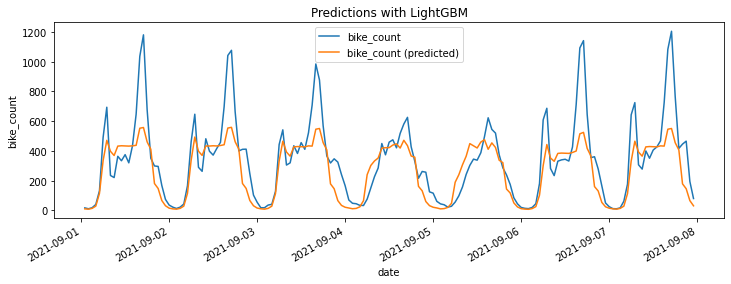

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x='date', y='bike_count', ax=ax)
df_viz.plot(x='date', y='bike_count (predicted)', ax=ax)
ax.set_title('Predictions with LightGBM')
ax.set_ylabel('bike_count')

In [10]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
print('RMSE: ', scores)
print(f'RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}')

RMSE:  [-0.72544926 -0.93469173 -0.71610878 -0.99793072 -0.86898395 -1.37143502]
RMSE (all folds): 0.936 ± 0.22


## Using external data

In [11]:
df_ext = pd.read_csv(Path('submissions') / 'starting_kit' / 'external_data.csv')
df_ext.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


You can find the detailed documentation for each feature [in this PDF](https://donneespubliques.meteofrance.fr/client/document/doc_parametres_synop_168.pdf) (in French). Here the only feature we consider is the temperature. We will use [pandas.merge_asof](https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.merge_asof.html) to merge on date, using the closest available date (since the sampling between the external data and the counter data).

In [12]:
# In this notebook we define the __file__ variable to be in the same conditions as when running the
# RAMP submission

__file__ = Path('submissions') /  'starting_kit' /  'estimator.py'


def _merge_external_data(X):
    file_path = Path(__file__).parent / 'external_data.csv'
    df_ext = pd.read_csv(file_path, parse_dates=['date'])
    print(df_ext)
    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X['orig_index'] = np.arange(X.shape[0])
    X = pd.merge_asof(X.sort_values('date'), df_ext[['date', 't', 'u', 'rr24', 'tend24']].sort_values('date'), on='date')
    # Sort back to the original order
    X = X.sort_values('orig_index')
    del X['orig_index']
    return X
    

In [13]:
X_train_merge = _merge_external_data(X_train)
columns_merge = X_train_merge.columns
columns_merge

      numer_sta                date    pmer  tend  cod_tend   dd   ff       t  \
0          7149 2021-01-01 00:00:00  100810    80         1  270  1.8  272.75   
1          7149 2021-01-01 03:00:00  100920   110         3  300  1.7  271.25   
2          7149 2021-01-01 06:00:00  100950    30         3  290  2.6  271.95   
3          7149 2021-01-01 09:00:00  101100   150         2  280  1.7  272.45   
4          7149 2021-01-01 12:00:00  101110    30         0   50  1.0  276.95   
...         ...                 ...     ...   ...       ...  ...  ...     ...   
3317       7149 2020-09-30 09:00:00  101540   -30         8  230  4.4  289.95   
3318       7149 2020-09-30 12:00:00  101320  -210         8  190  4.9  292.05   
3319       7149 2020-09-30 15:00:00  101140  -180         7  190  4.1  291.55   
3320       7149 2020-09-30 18:00:00  101020  -130         6  190  2.7  290.15   
3321       7149 2020-09-30 21:00:00  100880  -140         8  170  2.4  288.35   

          td   u  ...  hnua

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'date',
       'counter_installation_date', 'counter_technical_id', 'latitude',
       'longitude', 't', 'u', 'rr24', 'tend24'],
      dtype='object')

Similarly we can wrap this function into a FunctionTranformer to use it in a scikit-learn pipeline. Now let's see whether this additional feature improves the model,

In [17]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[['date']]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", 'counter_id', 'counter_name', 'site_id', 'counter_installation_date', 'counter_technical_id']

numeric_cols = ['t', 'u', 'rr24', 'tend24', 'latitude', 'longitude']

preprocessor = ColumnTransformer([
    ('date', "passthrough", date_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
    ('numeric', 'passthrough', numeric_cols)
])

regressor = lgb.LGBMRegressor()

pipe =  make_pipeline(
    FunctionTransformer(_merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor
)

## Feature importance

We can check the feature importances using the function [sklearn.inspection.permutation_importances](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html). Since the first step of our pipeline adds the temperature and extract the date components, we want to apply this transformation those steps, to check the importance of all features. Indeed, we can perform sklearn.inspection.permutation_importances at any stage of the pipeline.

In [18]:
merger = pipe[:2]
X_train_augmented = merger.transform(X_train)
X_test_augmented = merger.transform(X_test)

predictor = pipe[2:]
_ = predictor.fit(X_train_augmented, y_train)

      numer_sta                date    pmer  tend  cod_tend   dd   ff       t  \
0          7149 2021-01-01 00:00:00  100810    80         1  270  1.8  272.75   
1          7149 2021-01-01 03:00:00  100920   110         3  300  1.7  271.25   
2          7149 2021-01-01 06:00:00  100950    30         3  290  2.6  271.95   
3          7149 2021-01-01 09:00:00  101100   150         2  280  1.7  272.45   
4          7149 2021-01-01 12:00:00  101110    30         0   50  1.0  276.95   
...         ...                 ...     ...   ...       ...  ...  ...     ...   
3317       7149 2020-09-30 09:00:00  101540   -30         8  230  4.4  289.95   
3318       7149 2020-09-30 12:00:00  101320  -210         8  190  4.9  292.05   
3319       7149 2020-09-30 15:00:00  101140  -180         7  190  4.1  291.55   
3320       7149 2020-09-30 18:00:00  101020  -130         6  190  2.7  290.15   
3321       7149 2020-09-30 21:00:00  100880  -140         8  170  2.4  288.35   

          td   u  ...  hnua

In [19]:
from sklearn.inspection import permutation_importance
feature_importances = permutation_importance(
    predictor, X_train_augmented[:20000], y_train[:20000], n_repeats=10, random_state=0
)

In [20]:
sorted_idx = feature_importances.importances_mean.argsort()
sorted_idx

array([ 2,  3,  7,  4,  5,  6, 10, 11, 12,  9, 14,  8, 13, 15,  0,  1, 16])

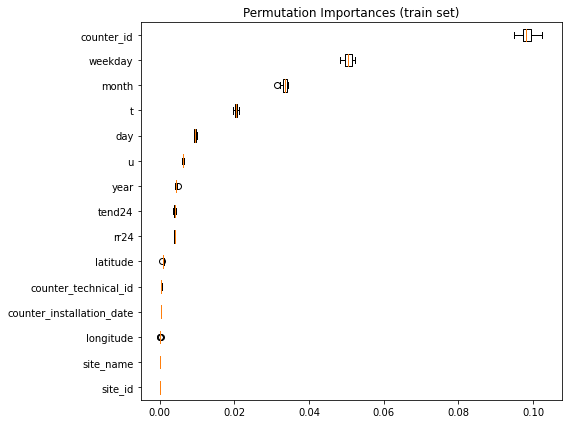

In [21]:
sorted_idx = feature_importances.importances_mean.argsort()


fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(feature_importances.importances[sorted_idx[:-2]].T,
           vert=False, labels=X_train_augmented.columns[sorted_idx[:-2]])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

## Detecting outliers

 Interesting data in the external data set are t, tx12 (which contains the same information as t as it is max temperature on the last 12 hours), u, tend24, rr24 and td